[View in Colaboratory](https://colab.research.google.com/github/Tejas163/Data-Science/blob/master/Amazon_Food_Review_k_NN_Final_Revised.ipynb)

# K-NN on Different models-(BagOfWords,TfIDF,AvgWord2Vec,TfIDF Weighted Word2Vec)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%matplotlib inline

#import all the modules
import sqlite3
import numpy as np
import pandas as pd
import nltk
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import metrics
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler

**Preprocessing**

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{"couldn't", 'we', 'these', 'hers', 'haven', 'y', 'itself', 'further', 'be', 'i', 'there', 'have', 'from', 'had', 'his', 'at', 'shan', 'most', 'ourselves', "needn't", 'when', 'same', 'they', 'while', 'very', 'my', "you'll", 'through', 'doesn', 'again', 'do', 'nor', 'below', 'wouldn', 'for', 'she', 'does', "you've", 'our', 'll', 'what', 'during', 'o', 'by', "haven't", 'into', 'ours', 'was', 'm', "isn't", 'this', 'until', 'some', 'just', 'which', 'whom', 'other', 'who', 'now', 'yourself', 'aren', "aren't", 'them', "you'd", "should've", 'can', 'did', 'or', 'all', 'isn', "weren't", "hasn't", 'won', 'to', 'd', 'were', "hadn't", "mightn't", 'wasn', 'himself', 'and', 'only', 'then', 'too', 'both', 'between', 'themselves', 'myself', 'down', 'didn', 'her', 'it', "wouldn't", "that'll", 'not', 'ma', 'because', 'but', 'been', 'him', 'mightn', 'being', 'than', 'off', 'how', "wasn't", 'such', 'your', 'weren', 't', 'am', 'as', 'yours', "doesn't", "didn't", 'that', 'own', 'needn', 're', 'over', "you'r

In [0]:
conn=sqlite3.connect('drive/My Drive/final2.sqlite')
conn.cursor()
conn.commit()
conn.text_factory=str
#final_data.to_sql('Reviews',conn,schema=None,if_exists='replace')

In [0]:
fd=pd.read_sql_query("""SELECT * FROM REVIEWS""",conn)

In [8]:
fd.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [0]:
conn2=sqlite3.connect('drive/My Drive/final.sqlite')

In [0]:
label_df=pd.read_sql_query("""SELECT * FROM REVIEWS""",conn2)

In [11]:
label_df.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...


In [0]:
label_df=label_df.sort_values('Time',axis=0,inplace=False,kind='quicksort')

In [9]:
label_df.shape

(364173, 12)

In [0]:
fd=fd.sort_values('Time',axis=0,inplace=False,kind='quicksort')

In [11]:
fd.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


# Since we have not much of RAM we are working on select set of samples

In [14]:
d_pos=label_df[label_df["Score"] == 'Positive'].sample(n=25000)
d_neg=label_df[label_df["Score"] == 'Negative'].sample(n=25000)
finald=pd.concat([d_pos,d_neg])
finald.shape

(50000, 12)

In [15]:
finald.head(2)
final_d=finald.sort_values(by='Time')
final_d.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,Positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
425,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,Negative,992217600,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton bring distinguish characterist ...
252,346112,374418,B00004CI84,A2E1UPR4LZJSF2,Ashley,2,2,Positive,1023235200,Beetlejuice! Beetlejuice! Beetlejuice!,What can I say? This is a CLASSIC! I've seen t...,say classic ive seen movi mani time actual wor...


# Bag Of Words KNN

In [48]:
X=final_d["CleanedText"]
X.shape

(50000,)

In [49]:
y=final_d["Score"]
y.shape

(50000,)

#Train and Test Split for the preprocessed text

In [0]:
#split the data into train and test fo bag of words

X_train,X_test,Y_train,Y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=0)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=cross_validation.train_test_split(X_train,Y_train,test_size=0.3)

In [17]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(35000,) (15000,) (35000,) (15000,)


**Bag of Words**

In [18]:
#Bag of Words
BoW=CountVectorizer()
X_train=BoW.fit_transform(X_train)
X_train=StandardScaler(with_mean=False).fit_transform(X_train)
x_test=BoW.transform(X_test)

print("the type of count vectorizer is:",type(X_train))
X_train.get_shape()
X_test=StandardScaler(with_mean=False).fit_transform(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>


In [20]:
X_test.shape

(15000, 30161)

In [19]:
Y_test.shape

(15000,)

# Optimal K

In [23]:
#with either k=8 or 9 we get best accuracy for test to be 91%,now with 10 fold cross validation we have to see if our ccuracy improves

n_list=list(range(0,20))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    scores_cv.append(scores.mean())

#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)




 the optimal k is 13.


In [24]:
#KNN with optimal k and test accuracy for bag of words
from sklearn.neighbors import KNeighborsClassifier
knn_opt=KNeighborsClassifier(n_neighbors=optimal_k)
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(X_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for bag of words model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for bag of words model with optimal k=13 is 70.606667%


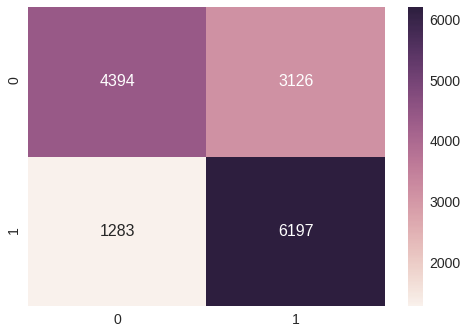

In [25]:
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size": 16}, fmt='g')

In [52]:
precision=6197/(6197+1283)
print(precision)
recall=6197/(6197+3126)
print(recall)

0.828475935828877
0.6647002037970611


Observations:
Precision for BoW:62%
recall for BoW:66%

# TF-IDF KNN

In [0]:
X_train,X_test,Y_train,Y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=0)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=cross_validation.train_test_split(X_train,Y_train,test_size=0.3)

In [59]:
tf_idf_vect=TfidfVectorizer()
final_tf_idf_vect=tf_idf_vect.fit_transform(X_train)
final_test_tfidf_vect=tf_idf_vect.transform(X_test)
X_train=StandardScaler(with_mean=False).fit_transform(final_tf_idf_vect)
X_test=StandardScaler(with_mean=False).fit_transform(final_test_tfidf_vect)
final_tf_idf_vect.get_shape(),final_test_tfidf_vect.get_shape()
print(X_train.shape,X_test.shape)

(35000, 30224) (15000, 30224)


In [34]:
X_test.shape

(15000, 30161)

In [35]:
Y_test.shape

(15000,)

**Optimal K**

In [36]:
#for finding optimal k with odd list for neighbors
n_list=list(range(0,30))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    scores_cv.append(scores.mean())

#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)


 the optimal k is 1.


In [39]:
#KNN with optimal k and test accuracy for tf_idf model

knn_opt=KNeighborsClassifier(n_neighbors=optimal_k)
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(X_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for bag of words model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for bag of words model with optimal k=1 is 57.626667%


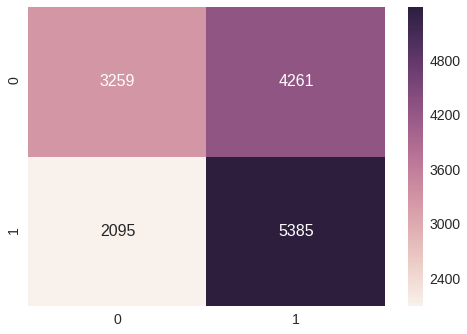

In [41]:
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size": 16}, fmt='g')

In [51]:
TPR=5385/(5385+4261)
print(TPR)
precision=5385/(5385+2095)
print(precision)

0.5582624922247563
0.7199197860962567


Observations

Recall(TPR) from the confusion matrix is: 55%
Precision=71%

# AvgWord2Vec KNN

In [0]:
!pip install gensim

In [0]:
import gensim
from gensim.models import word2vec,KeyedVectors

In [101]:
#model=word2vec.Word2Vec.load('drive/My Drive/w2vmodel')
#model

In [25]:
X=final_d["CleanedText"]
X.shape

(50000,)

In [26]:
y=final_d["Score"]
y.shape


(50000,)

In [0]:
X_train,X_test,Y_train,Y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=0)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=cross_validation.train_test_split(X_train,Y_train,test_size=0.3)

In [28]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(35000,) (35000,) (15000,) (15000,)


In [0]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [29]:
#word2vec own model
i=0
list_of_sentence=[]
for sent in X_train:
    filtered_sentence=[]
    list_of_sentence.append(sent.split())
    #sent=cleanhtml(sent)
    #for w in sent.split():
      #   for cleaned in cleanpunc(w).split():
      #      if(cleaned.isalpha()):
       #         filtered_sentence.append(cleaned.lower())
        #    else:
         #       continue
#list_of_sentence.append(filtered_sentence)
#print(X["CleanedText"].values[0])
#print('###########')
print(list_of_sentence[0])
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

words=list(w2v_model.wv.vocab)
print(len(words))

['sure', 'get', 'mani', 'five', 'star', 'bought', 'pack', 'costco', 'age', 'white', 'mild', 'cheddar', 'tast', 'lack', 'real', 'chees', 'tast', 'bought', 'said', 'organ', 'figur', 'would', 'healthier', 'option', 'cheat', 'food', 'creami', 'kid', 'hard', 'enough', 'sauc', 'coat', 'shell', 'age', 'doesnt', 'even', 'come', 'close', 'tast', 'like', 'age', 'cheddarpretti', 'much', 'mild', 'star', 'attempt', 'make', 'strong', 'flavour', 'mac', 'chees', 'though', 'say', 'like', 'strong', 'chees', 'balderson', 'year', 'cheddar', 'asiago', 'etc', 'kraft', 'flavour', 'like', 'sharp', 'cheddar', 'even', 'add', 'meat', 'still', 'keep', 'flavour', 'other', 'tast', 'anni', 'like', 'mild', 'medium', 'cheddar', 'mayb', 'eat', 'stuff', 'find', 'ad', 'real', 'chees', 'get', 'tast', 'exact', 'sure', 'call', 'mass', 'produc', 'food', 'organ', 'law', 'chang', 'take', 'bite', 'type', 'thattast', 'like', 'noodl', 'butter']
8215


In [30]:
words=list(w2v_model.wv.vocab)
print(len(words))

8215


In [31]:
w2v_model.wv.most_similar('like')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('okay', 0.7647310495376587),
 ('weird', 0.670545756816864),
 ('remind', 0.6595607995986938),
 ('funni', 0.6455897688865662),
 ('appeal', 0.641618549823761),
 ('sort', 0.6399711966514587),
 ('prefer', 0.6290032267570496),
 ('strang', 0.6275856494903564),
 ('gross', 0.6266273856163025),
 ('resembl', 0.617561399936676)]

In [32]:
#word2vec for test
i=0
list_of_sentences=[]
for sent in X_test:
    filtered_sentences=[]
    list_of_sentences.append(sent.split())
    #sent=cleanhtml(sent)
    #for w in sent.split():
     #   for cleaned in cleanpunc(w).split():
      #      if(cleaned.isalpha()):
       #         filtered_sentence.append(cleaned.lower())
        #    else:
         #       continue
#list_of_sentences.append(filtered_sentence)
#print(X_train.values[0])
#print('###########')
print(list_of_sentences[0])
w2v_model_test=gensim.models.Word2Vec(list_of_sentences,min_count=5,size=50,workers=4)

words_test=list(w2v_model_test.wv.vocab)
print(len(words))


['year', 'old', 'rescu', 'belgian', 'shepherd', 'groenendael', 'pass', 'short', 'year', 'stay', 'newbi', 'pet', 'care', 'samantha', 'sammi', 'came', 'life', 'initi', 'feed', 'one', 'advertis', 'dog', 'food', 'femal', 'shed', 'twice', 'year', 'case', 'month', 'year', 'aw', 'point', 'almost', 'go', 'insan', 'love', 'hate', 'beauti', 'dog', 'research', 'internet', 'ask', 'anyon', 'could', 'solut', 'sammi', 'problem', 'even', 'tri', 'brand', 'wouldnt', 'eat', 'becam', 'cost', 'final', 'petco', 'repres', 'turn', 'well', 'senior', 'blend', 'special', 'blend', 'minus', 'filler', 'etc', 'vitamin', 'plus', 'condrodin', 'hip', 'problem', 'gradual', 'adjust', 'diet', 'period', 'coupl', 'week', 'well', 'rich', 'dog', 'food', 'dog', 'need', 'adjust', 'new', 'food', 'love', 'tast', 'short', 'period', 'time', 'shed', 'almost', 'came', 'stop', 'along', 'dandruff', 'pass', 'found', 'groenendael', 'need', 'brush', 'daili', 'least', 'sever', 'time', 'week', 'regular', 'need', 'bath', 'expert', 'say', 'br

In [33]:
w2v_model_test.wv.most_similar('like')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('aw', 0.8327149152755737),
 ('nasti', 0.8172328472137451),
 ('odd', 0.8134945631027222),
 ('strang', 0.8107452392578125),
 ('weird', 0.8070507645606995),
 ('gross', 0.7871053218841553),
 ('bland', 0.7816669344902039),
 ('overwhelm', 0.7701141238212585),
 ('appeal', 0.7663282155990601),
 ('terribl', 0.761405348777771)]

In [77]:
sent_vectors = [] 
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

vec_avg=np.array(sent_vectors)

35000
50


In [78]:
sent_vectors_test = [] 
for sent in list_of_sentences: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(len(sent_vectors[0]))

vec_avg_2=np.array(sent_vectors_test)

15000


In [31]:
print(len(sent_vectors_test))

15000


In [30]:
vec_avg_2=np.array(sent_vectors_test)
vec_avg_2.shape

(15000, 50)

In [0]:
X_train=vec_avg
X_test=vec_avg_2

In [80]:
#for finding optimal k with odd list for neighbors
n_list=list(range(0,30))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    scores_cv.append(scores.mean())


#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)


 the optimal k is 29.


In [81]:
#KNN with optimal k and test accuracy for AvgWord2Vec model

knn_opt=KNeighborsClassifier(n_neighbors=optimal_k)
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(X_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for AvgWord2Vec model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for AvgWord2Vec model with optimal k=29 is 72.646667%


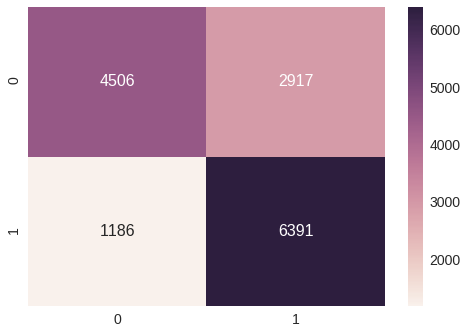

In [82]:
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size": 16}, fmt='g')

In [53]:
precision=6391/(6391+1186)
print(precision)
recall=6391/(6391+2917)
print(recall)

0.8434736703180679
0.686613665663945


Observations
For Avg W2Vec:
precision:84%
recall:68%


# Weighted Tf-Idf Word2Vec KNN

In [16]:
X=final_d["CleanedText"]
X.shape

(50000,)

In [17]:
y=final_d["Score"]
y.shape

(50000,)

In [0]:
#split the data into train and test fo tf-idf

X_train,X_test,Y_train,Y_test=cross_validation.train_test_split(X,y,test_size=0.3,random_state=0)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=cross_validation.train_test_split(X_train,Y_train,test_size=0.3)

In [19]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(35000,) (15000,) (35000,) (15000,)


In [20]:
tf_idf_vect=TfidfVectorizer()
final_tf_idf_vect=tf_idf_vect.fit_transform(X_train)
final_test_tfidf_vect=tf_idf_vect.transform(X_test)
#X_train=StandardScaler(with_mean=False).fit_transform(final_tf_idf_vect)
#X_test=StandardScaler(with_mean=False).fit_transform(final_test_tfidf_vect)
final_tf_idf_vect.get_shape(),final_test_tfidf_vect.get_shape()
print(X_train.shape,X_test.shape)

(35000,) (15000,)


In [0]:
tf_idf_features = tf_idf_vect.get_feature_names() # tfidf words/col-name

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tf_idf_features = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sentence: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length                          
    weight_sum =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
      try:
        vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
        tfidf = tf_idf_vect[row, tfidf_feat.index(word)]
        sent_vec += (vec * tf_idf)
        weight_sum += tf_idf
        
      except:
            pass
        
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [44]:
tf_idf_features = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sentences: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
      try:
        vec = w2v_model_test[word]
            # obtain the tf_idfidf of a word in a sentence/review
        tfidf = tf_idf_vect[row, tfidf_feat.index(word)]
        sent_vec += (vec * tf_idf)
        weight_sum += tf_idf
        
      except:
            pass
        
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [0]:
X_train=np.array(tfidf_sent_vectors)
X_test=np.array(tfidf_sent_vectors_test)

In [46]:
X_train.shape,X_test.shape

((35000, 50), (15000, 50))

In [47]:
#for finding optimal k with odd list for neighbors
n_list=list(range(0,30))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    scores_cv.append(scores.mean())

#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)


 the optimal k is 1.


In [48]:
#KNN with optimal k and test accuracy for Weighted TfIDF Word2Vec model

knn_opt=KNeighborsClassifier(n_neighbors=optimal_k)
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(X_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for TfIdf Word2Vec model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for TfIdf Word2Vec model with optimal k=1 is 49.833333%


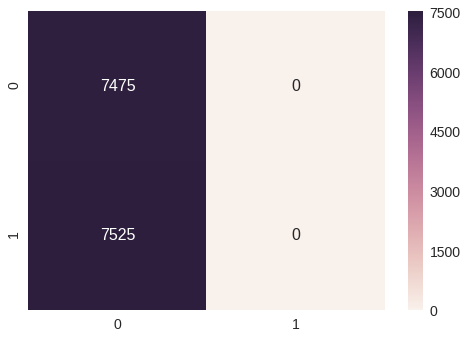

In [49]:
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size": 16}, fmt='g')

In [0]:
precision=0
recall=0

Conclusion/Observation

From the above with Avg W2Vec we get the highest precision at 84%
